In [1]:
#### FEATURE IMPORTANCE ANALYSIS ####
# feature pertubation #

/pfs/data5/home/kit/stud/updzl/Experiment 1
/pfs/data5/home/kit/stud/updzl/Experiment 1


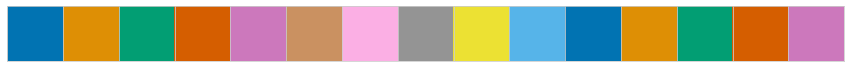

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import torch
#from google.colab import drive
import os
import torch
from torch import nn, optim
from torch.optim import Adam
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
#!pip install torch pytorch-lightning
#import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torch.utils.data import TensorDataset, DataLoader
#import torchvision
#from torch.utils.tensorboard import SummaryWriter
import datetime
import csv
import time
import random
###
# Ralf Loritz 15.2.2022
# Rainfall-runoff using LSTM Models
# Pytorch
###
#%load_ext autoreload
#%autoreload 2 #Reload all modules every time before executing the Python code typed.

# built-in
import os
import importlib
import math
import collections
###
# addtional packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# set torch seed
def setup_seed(seed):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    #torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  



# import from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

# import own loss functions
#from src.loss_functions import kge, kgeprime, nse, rmse
#from src.ML_functions import onehot_encode_pd, lagged_features, get_scaler
#from src.ML_train import train_model

#-----------------------
#import src.ML_train
#importlib.reload(src.ML_train)
#from src.ML_train import train_model
#----------------------


###
# set plot style seaborn
sns.set_style("whitegrid")

# set colors
current_palette = sns.color_palette("colorblind", 15)
sns.palplot(current_palette)
print(os.getcwd())
# set workspcae
os.chdir('./')
print(os.getcwd())

In [3]:
###
# identify GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
# set cuda0 as GPU
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')

4
Tesla V100-SXM2-32GB


In [4]:
# Preprocessing etc.


# Creates a training, validation and test data set
# Check https://onlinelibrary.wiley.com/doi/abs/10.1029/2021WR031523 for split sampling approaches in hydrological modeling
# Validation period is usually very small and is used to check the performance of the model during the training on a out-of-sample batch
# to monitor evtl. overfitting
def split_data(start_train, end_train, start_val, end_val, start_test, end_test, df):
  ''' split data set into training period, validation period (for hyperparameter tuning) and independent test period.
  periods should correlate with benchmark model. 
  input in date time format or any other indexing used in df(dataframe)'''
  train = df.loc[start_train:end_train]
  val = df.loc[start_val:end_val]
  test = df.loc[start_test:end_test]
  return train, val, test

# Standardizes data for the network, to avoid scaling issues. Uses own metrics.
def local_standartization(data):
  ''' z-standartisation on the the all the data, statistic values taken from training period'''
  stds = data.std()
  mean = data.mean()
  scaled_data = (data-mean)/stds
  return scaled_data, stds, mean

# Standartizes data for network with given metrics(from training data set)
def scale(data, stds, mean):
  scaled_data = (data-mean)/stds
  return scaled_data

# Performance metrics:
# NSE function
def get_nse(y_test, predictions):
  assert len(y_test) == len(predictions)  
  numerator = sum([(y_test[i]-predictions[i])**2 for i in range(len(y_test))])
  y_test_avg = sum(y_test)/len(y_test)
  denominator = sum([(y_test[i]-y_test_avg)**2 for i in range(len(y_test))])
  NSE = 1- (numerator/denominator)
  return NSE

# NSE1 as loss function 
def NSE1_loss(obs, target):
    obs_mean = torch.mean(obs)
    denominator = torch.sum(abs(torch.sub(obs, obs_mean)))
    nominator = torch.sum(abs(torch.sub(obs, target)))
    loss = nominator/denominator
    return loss

# KGE 2009
def kge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return np.vstack((kge_, r, alpha, beta))

# Takes pandas df and lists with strings which denote target and feature columns, as well as a desired sequence length.
# inherits from pytorch Datafram function
# outputs a list containing 2 tensors: 1 with features (including the respective sequence) and 1 with the corresponding target(label)
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).to(cuda0).float()
        self.X = torch.tensor(dataframe[features].values).to(cuda0).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [5]:
# 22.04.22 
# LSTM model taken from Ralfs version 1.1
# Reviewed by Jean-Paul 26.04.22


class ShallowRegressionLSTM(nn.Module):                                                                       # define new class which inherits from the nn.Module                                           
    def __init__(self, input_size, hidden_size, num_layer, drop_out):                                                   # define constructor, includes objects attributs which must be defined when instantiating given object
        super().__init__()                                                                                    
        self.input_size = input_size                                                                          # this is the number of features
        self.hidden_size = hidden_size                                                                        # number of nodes per layer (identical layer size over ll layers, otherwise multiple attributes for hidden size )
        self.num_layers = num_layer                                                                           # number of layers per instantiated nn.LSTM (1 here)
        #self.drop_out = drop_out
        
        self.lstm_1 = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              batch_first = True,
                              num_layers=num_layer,
                              #drop_out = drop_out
                             )
        #self.lstm_2 = nn.LSTM(input_size = hidden_size,                                                       # input for the second layer is the output of the previous layer i.e. the hidden states of the previous layer (size=hiden_size)
         #                     hidden_size = hidden_size,
          #                    batch_first = True,
           #                   num_layers=num_layer)
            
        self.dropout = torch.nn.Dropout(drop_out)                                                             # dropout layer for regualitation http://jmlr.org/papers/v15/srivastava14a.html
        
        
        self.linear = nn.Linear(in_features=self.hidden_size,                                                 # linear or so called Dense-layer, which takes hidden states from previous layer (size=lstm_2(hidden_size)) as input and calculates an output (size=output_features) with linear transformation (y=W*x+b)
                                out_features=1)                                                               # and calculates an output (size=output_features) with linear transformation (y=W*x+b)           

        
    def forward(self, x):
        batch_size = x.shape[0]
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)            # initial hidden_states with zeros, requires_grad let pytorch track operations on tensor, to(cuda0) moves tensor to your device (here: GPU)
        #h1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)            # initial cell states
        
        # initialize the cell state:
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)
        #c1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)
        
        out, (hn_1, cn_1) = self.lstm_1(x, (h0.detach(), c0.detach()))                                        # out: batch_size, sequence_length, hidden_size; h_n & c_n: num_layers, hidden_size
        #out = self.dropout(out)                                                                               # detach????
        #out, (hn_2, cn_2) = self.lstm_2(out, (h1.detach(), c1.detach()))                                      
        out = out[:,-1,:]                                                                                     # many to one / sequence to one
        out = self.dropout(out)
        out = self.linear(out)  # First dim of Hn is num_layers, which is set to 1 above.

        return out, (hn_1.transpose(0,1), cn_1.transpose(0,1)),
                    #(hn_2.transpose(0,1), cn_2.transpose(0,1)
                    

In [6]:
# Create a drectory for  your datafiles which containes filenames 
data_directory = os.listdir(path='/pfs/data5/home/kit/stud/updzl/data')
print('Files found: '+str(data_directory))
data_directory.pop(2)
# Define the current folder with the files 
os.chdir('/pfs/data5/home/kit/stud/updzl/data')
# loop through the directory and load the dataframes directly into local memory. filenames become df names, the .replace method can
# change those names. check the read_csv method for argumentexplanations, they differ on the strucutre of your data set 
# (header = line of column names etc.)
for i in range(len(data_directory)):
   locals()[str(data_directory[i]).replace('inclERA5.txt', '')]= pd.read_csv(str(data_directory[i]), header=0, parse_dates=[0], index_col =[0])

Files found: ['HuewelerbachinclERA5.txt', 'SchwebichinclERA5.txt', '.ipynb_checkpoints', 'WeierbachinclERA5.txt', 'MierbechinclERA5.txt', 'BibeschbachinclERA5.txt']


In [7]:
# Define Hyperparameters in dictionary 
# check http://arxiv.org/abs/1206.5533 for a comrehensive overview over the different hyperparameters involved and their impact

model_params = {
  "batch_size": 64,
  "batch_size_e": 512,
  "sequence_length": 512,
  "hidden_size": 256,            # set hidden_size of model i.e. number of nodes per hidden layer
  "num_layer":1,  
  "num_epochs": 5,                # number of training epochs, start high and use the validation dataset after each epoch to check the performance metric 
                                # on an out of batch example, choose the number of epoch with the best validation performance and not the best training
                                # performance
  "drop_out": 0.5,              # set drop_out of model for regularization
  "learning_rate": 0.0005,       # set learning rate which is responsible for how strongly the optimization algorithm adapts the model parameters after
                                # a training epoch
  "loss": torch.nn.MSELoss(),   # set loss function: regression task --> mean squared error, already defined in torch framework, possible to write own
  "set_forget_gate": 3,  
  "adapt_learning_rate_epoch": 1,
  "adapt_gamma_learning_rate": 0.5,
  "adapt_end": 0 ,
  "swa_start": 30,            # start stochastic weight averaging
  "swa_learning_rate": 0.0001,
  "grad_clip" : 'on',            # add gradient clipping
  "max_norm" : 1,                #define max gradient
}

model_params = collections.OrderedDict(model_params)

In [8]:
# Define validation period
start_train = '2010-10-01 00:00:00'
end_train = '2021-09-30 23:30:00'
start_val = '2009-10-01 00:00:00'
end_val = '2010-09-30 23:30:00'
start_test = '2004-10-01 00:00:00'
end_test = '2010-09-30 00:00:00'
# Define catchment
catchment = Huewelerbach.copy(deep=True)
catchment_str = 'Huewelerbach'
# Drop excessive columns
excess_name = [col for col in catchment.columns if 'Inter' in col]
catchment.drop(labels=excess_name, axis=1, inplace=True)
catchment.drop(labels=['Q_flag', 'T_flag'], axis=1, inplace=True)
# Adding additional data (i.e. rainfall) from neighbouring catchments (stations)
if catchment_str == 'Bibeschbach':
  neighbouring_catchment_A = Mierbech
  #neighbouring_catchment_B = Schwebich
elif catchment_str == 'Huewelerbach':
  neighbouring_catchment_A = Schwebich
  neighbouring_catchment_B = Weierbach
elif catchment_str == 'Mierbech':
  neighbouring_catchment_A = Bibeschbach
  #neighbouring_catchment_B = Schwebich
elif catchment_str == 'Weierbach':
  neighbouring_catchment_A = Huewelerbach
  neighbouring_catchment_B = Schwebich
elif catchment_str == 'Schwebich':
  neighbouring_catchment_A = Huewelerbach
  neighbouring_catchment_B = Weierbach
else:
  raise ValueError(catchment_str+' not found')
col_name_A = [col for col in neighbouring_catchment_A.columns if 'P_' in col]
col_name_B = [col for col in neighbouring_catchment_B.columns if 'P_' in col]
catchment[str(col_name_A[0])] = neighbouring_catchment_A[col_name_A[0]]
catchment[str(col_name_A[1])] = neighbouring_catchment_A[col_name_A[1]]
catchment[str(col_name_B[0])] = neighbouring_catchment_B[col_name_B[0]]
catchment[str(col_name_B[1])] = neighbouring_catchment_B[col_name_B[1]]
print(catchment_str+' dataset column names '+str(list(catchment)))
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1')
catchment.to_csv('s')

# Split and then Standardize the data (z-standartization)
train, val, test = split_data(start_train, end_train, start_val, end_val, start_test, end_train, catchment)
train_scaled, stds, mean = local_standartization(train)
#val_scaled = scale(val, stds, mean)
#test_scaled = scale(test, stds, mean)

# Save feature column names as string in list
features = list(catchment)
# removes target column from feature list
features.remove('Q_'+catchment_str)
# save target column name
target = 'Q_'+catchment_str

#load model
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1/Best_Performances/'+catchment_str)
ann_model = ShallowRegressionLSTM(input_size = len(features),
                       hidden_size = model_params["hidden_size"],
                       num_layer=1,
                       drop_out = model_params["drop_out"]
                                 ).to(cuda0)
#load state parameters
ann_model.load_state_dict(torch.load('20220725-120341_Huewelerbach_model_C_s330000_Epoch_1', map_location=cuda0  ))

#Pertubation and evaluation
seeds = np.array([42, 69, 420, 2020, 1888]) #
# observed runoff
df_test = catchment['2004-10-11 16:00:00':end_test]
obs=df_test['Q_'+catchment_str].values
# for each column in the dataframe
NSE_list = []
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1')
dfc = pd.read_csv('s', header=0, parse_dates=[0], index_col =[0])
# loop over features
for i in features:
    pertubed_feature_name = i
    print(str(pertubed_feature_name)+' perturbation')
    pertubed_feature_value = catchment[i].values
    df = dfc.copy(deep=True)
    NSE_seed_list = []
    for i in seeds:
        seed = i
        print('random shuffle, seed value = ' + str(seed))
        setup_seed(seed)
        np.random.shuffle(pertubed_feature_value)
        df[pertubed_feature_name]=pertubed_feature_value
        
        # scale and split data
        train, val, test = split_data(start_train, end_train, start_val, end_val, start_test, end_train, df)
        test_scaled = scale(test, stds, mean)
        # Save feature column names as string in list
        features = list(train_scaled)
        # removes target column from feature list
        features.remove('Q_'+catchment_str)
        # save target column name
        target = 'Q_'+catchment_str
        # Create datasets including tensors of features and targets
        test_set = SequenceDataset(test_scaled, target, features, sequence_length=model_params['sequence_length'])
        # delete the first int[sequence_length] from datasets
        test_set.X = test_set.X[model_params['sequence_length']:, :]
        test_set.y = test_set.y[model_params['sequence_length']:, ]
        # Insert datasets into pytorchs own DataLoader class, which automates the batching of the sammples for later use in the actual model
        test_loader = DataLoader(test_set, batch_size=model_params['batch_size'], shuffle = False, drop_last = True)
        # Model run
        ann_model.eval()
        with torch.no_grad():
            output = np.array([])
            for batch, _ in test_loader:
                y_pred,_  = ann_model(batch) # forward call
                new = y_pred.flatten().cpu().detach().numpy()
                output = np.append(output, new)
        #Eval
        output_rescaled=(output*stds.loc['Q_'+catchment_str])+mean.loc['Q_'+catchment_str]
        sim = output_rescaled
        NSE = get_nse(obs[:], sim[:len(obs)])
        print('NSE = '+str(NSE))
        #save in list
        NSE_seed_list.append(NSE)
    NSE_list.append(NSE_seed_list)
    
results = pd.DataFrame(NSE_list[1:], columns=NSE_list[0])
print(results)

Huewelerbach dataset column names ['P_Koerich', 'T_Koerich', 'Q_Huewelerbach', 'EVAP_Koerich', 'cape', 'cin', 'kx', 'q', 'rh', 'tcwv', 'windspeed', 'LLS', 'DLS', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'P_Useldange', 'EVAP_Useldange', 'P_Roodt', 'EVAP_Roodt']
P_Koerich perturbation
random shuffle, seed value = 42
NSE = 0.4474779104751936
random shuffle, seed value = 69
NSE = 0.4532790586866947
random shuffle, seed value = 420
NSE = 0.44891513952545314
random shuffle, seed value = 2020
NSE = 0.4522154093490862
random shuffle, seed value = 1888
NSE = 0.4525216869127737
T_Koerich perturbation
random shuffle, seed value = 42
NSE = 0.6284487618021282
random shuffle, seed value = 69
NSE = 0.6281110177869507
random shuffle, seed value = 420
NSE = 0.626263684221586
random shuffle, seed value = 2020
NSE = 0.62798745705796
random shuffle, seed value = 1888
NSE = 0.6277145454770652
EVAP_Koerich perturbation
random shuffle, seed value = 42
NSE = 0.6153196349691117
random shuffle, seed value = 69
NSE =

In [9]:
test_set.X.shape

torch.Size([296046, 20])

In [10]:
print(mean)

P_Koerich          0.045229
T_Koerich          9.610539
Q_Huewelerbach     0.009323
EVAP_Koerich       0.047418
cape              36.790559
cin               10.341051
kx                 8.706427
q                  0.002265
rh                52.797564
tcwv              16.133826
windspeed         11.165104
LLS                7.076639
DLS               14.752276
swvl1              0.341218
swvl2              0.336307
swvl3              0.337986
swvl4              0.368308
P_Useldange        0.041355
EVAP_Useldange     0.048448
P_Roodt            0.054541
EVAP_Roodt         0.046342
dtype: float64


In [11]:
results_t = results.T

In [12]:
 first_row = results_t.index

In [13]:
first_row.to_numpy()

array([0.44747791, 0.45327906, 0.44891514, 0.45221541, 0.45252169])

In [14]:
results_t.insert(0, 'col_name', first_row)

In [15]:
results_new = pd.DataFrame(data=results_t.values, columns=features)

In [16]:
results_new.loc['mean'] = results_new.mean()

In [17]:
results_new

,P_Koerich,T_Koerich,EVAP_Koerich,cape,cin,kx,q,rh,tcwv,windspeed,LLS,DLS,swvl1,swvl2,swvl3,swvl4,P_Useldange,EVAP_Useldange,P_Roodt,EVAP_Roodt
0,0.447478,0.628449,0.615320,0.643297,0.635931,0.625524,0.632224,0.645062,0.634564,0.608994,0.615527,0.641742,0.499709,0.525996,0.583010,0.449133,0.541883,0.605519,0.577795,0.616578
1,0.453279,0.628111,0.615063,0.643074,0.636188,0.624176,0.632472,0.643905,0.634773,0.609007,0.615992,0.642708,0.499989,0.526823,0.583800,0.447209,0.549869,0.606093,0.578323,0.617591
2,0.448915,0.626264,0.616798,0.644137,0.637109,0.625133,0.632816,0.646354,0.634890,0.610851,0.617185,0.641954,0.502133,0.527718,0.583513,0.445814,0.546023,0.608169,0.577903,0.618150
3,0.452215,0.627987,0.615242,0.643764,0.636811,0.625939,0.631928,0.643980,0.634592,0.608755,0.614693,0.643154,0.500751,0.527984,0.581887,0.449378,0.540517,0.607688,0.574012,0.618397
4,0.452522,0.627715,0.616703,0.644781,0.636039,0.623966,0.632181,0.644457,0.634801,0.610266,0.616051,0.642880,0.499837,0.527992,0.582105,0.448704,0.543586,0.607754,0.576105,0.618464
mean,0.450882,0.627705,0.615825,0.643811,0.636416,0.624947,0.632324,0.644752,0.634724,0.609575,0.615889,0.642488,0.500484,0.527303,0.582863,0.448048,0.544376,0.607044,0.576828,0.617836


In [18]:
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1')
results_new.to_csv('feature_importance_results_Huewelerbach')

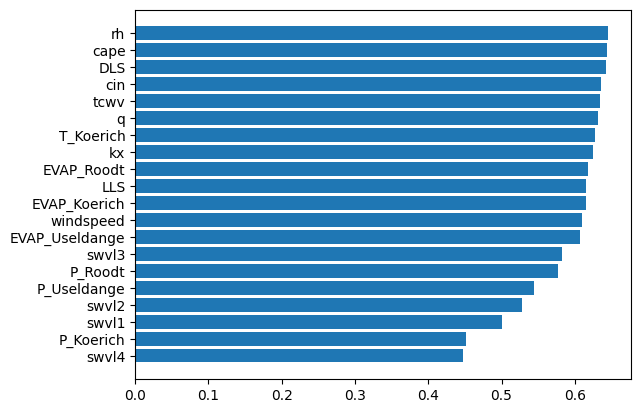

In [19]:
results_sorted = (results_new.sort_values(by = 'mean', axis=1))

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(results_sorted.columns, results_sorted.loc['mean'])
#ax.set_yticks(y_pos, labels=people)
#ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xlabel('Performance')
#ax.set_title('How fast do you want to go today?')

plt.show()

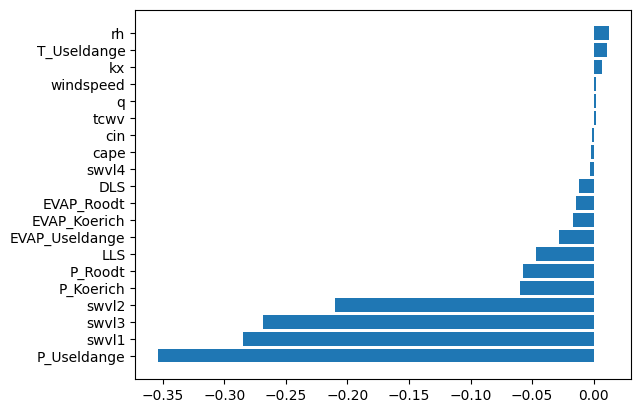

In [20]:
schwebich = pd.read_csv('feature_importance_results_Schwebich', index_col=[0])
results_sorted = (schwebich.sort_values(by = 'mean', axis=1))-0.8

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(results_sorted.columns, results_sorted.loc['mean'])
#ax.set_yticks(y_pos, labels=people)
#ax.invert_yaxis()  # labels read top-to-bottom
#ax.set_xlabel('Performance')
#ax.set_title('How fast do you want to go today?')

plt.show()

In [21]:
#plt.plot(df['DLS'].loc['2008-01-01 00:00:00':'2009-01-01 00:00:00'])
sns.scatterplot(df['Q_Weierbach'].loc['2008-01-01 00:00:00':'2009-01-01 00:00:00']*100, df['DLS'].loc['2008-01-01 00:00:00':'2009-01-01 00:00:00'])

KeyError: 'Q_Weierbach'

In [ ]:
df